# Data Preparation

### Import Libraries

In [519]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import zipfile
import matplotlib.pyplot as plt
import zipfile
import os
import ast

In [520]:
cd 

C:\Users\emmam


In [521]:
cd Documents

C:\Users\emmam\Documents


In [522]:
cd Flatiron

C:\Users\emmam\Documents\Flatiron


In [523]:
cd phase_2

C:\Users\emmam\Documents\Flatiron\phase_2


In [524]:
cd film-analytics

C:\Users\emmam\Documents\Flatiron\phase_2\film-analytics


In [525]:
cd data

C:\Users\emmam\Documents\Flatiron\phase_2\film-analytics\data


### Database Connection and Table Overview


In [526]:
conn = sqlite3.connect('im.db')

In [527]:
pd.read_sql("""SELECT name FROM sqlite_master WHERE type='table';""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [528]:
imdb_movie_info = pd.read_sql("""SELECT primary_title, start_year, primary_name AS director
FROM persons
JOIN directors ON persons.person_id = directors.person_id
JOIN movie_basics ON directors.movie_id = movie_basics.movie_id;""", conn)

In [529]:
imdb_movie_info.head()

,primary_title,start_year,director
0,Paano na kaya,2010,Ruel S. Bayani
1,Paano na kaya,2010,Ruel S. Bayani
2,Paano na kaya,2010,Ruel S. Bayani
3,Paano na kaya,2010,Ruel S. Bayani
4,No Other Woman,2011,Ruel S. Bayani


In [530]:
imdb_movie_info.drop_duplicates(inplace=True)

In [531]:
imdb_movie_info.shape

(163049, 3)

### Loading Datasets

In [532]:
movie_gross = pd.read_csv('bom.movie_gross.csv.gz')
movie_info = pd.read_csv('rt.movie_info.tsv.gz', delimiter='\t')
movie_reviews = pd.read_csv('rt.reviews.tsv.gz', delimiter='\t', encoding='latin-1')
movie_votes = pd.read_csv('tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('tn.movie_budgets.csv.gz')

In [533]:
def remove_special_characters(df, column_name):
    df[column_name] = df[column_name].str.replace('[^a-zA-Z0-9 ]', '', regex=True)
    return df

movie_gross = remove_special_characters(movie_gross, 'title')
movie_votes = remove_special_characters(movie_votes, 'title')
imdb_movie_info = remove_special_characters(imdb_movie_info, 'primary_title')

movie_gross['title'] = movie_gross['title'].str.lower().str.strip()
movie_votes['title'] = movie_votes['title'].str.lower().str.strip()
movie_budgets['movie'] = movie_budgets['movie'].str.lower().str.strip()
imdb_movie_info['primary_title'] = imdb_movie_info['primary_title'].str.lower().str.strip()

merged_data = pd.merge(movie_gross, movie_votes, how='inner', left_on='title', right_on='title')
merged_data = pd.merge(merged_data, movie_budgets, how='inner', left_on='title', right_on='movie')

df = pd.merge(imdb_movie_info, merged_data, left_on='primary_title', right_on='movie', how='inner')

df.head()

,primary_title,start_year,director,title,studio,domestic_gross_x,foreign_gross,year,Unnamed: 0,genre_ids,...,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,movie,production_budget,domestic_gross_y,worldwide_gross
0,blue valentine,2010,Derek Cianfrance,blue valentine,Wein.,9700000.0,2600000,2010,178,"[18, 10749]",...,8.994,2010-12-29,6.9,1677,25,"Dec 29, 2010",blue valentine,"$1,000,000","$9,737,892","$16,566,240"
1,blue valentine,2010,Derek Cianfrance,blue valentine,Wein.,9700000.0,2600000,2010,2673,"[18, 10749]",...,8.994,2010-12-29,6.9,1677,25,"Dec 29, 2010",blue valentine,"$1,000,000","$9,737,892","$16,566,240"
2,the place beyond the pines,2012,Derek Cianfrance,the place beyond the pines,Focus,21400000.0,14100000,2013,7960,"[18, 80]",...,12.960,2013-03-27,6.9,2781,67,"Mar 29, 2013",the place beyond the pines,"$15,000,000","$21,403,519","$47,011,449"
3,the light between oceans,2016,Derek Cianfrance,the light between oceans,BV,12500000.0,13400000,2016,17387,"[18, 10749]",...,29.887,2016-09-02,7.1,831,34,"Sep 2, 2016",the light between oceans,"$20,000,000","$12,545,979","$22,281,732"
4,out of the furnace,2013,Scott Cooper,out of the furnace,Rela.,11300000.0,4300000,2013,8055,"[53, 18, 80]",...,9.139,2013-12-06,6.6,1077,41,"Dec 4, 2013",out of the furnace,"$22,000,000","$11,330,849","$15,434,375"


In [534]:
movie_info = pd.read_csv('rt.movie_info.tsv.gz', delimiter='\t')
movie_reviews = pd.read_csv('rt.reviews.tsv.gz', delimiter='\t', encoding='latin-1')

merged_rt_data = pd.merge(movie_info, movie_reviews, on='id', how='left')

merged_rt_data.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,review,rating_y,fresh,critic,top_critic,publisher,date
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0.0,Patrick Nabarro,"November 10, 2018"
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0.0,io9.com,"May 23, 2018"
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0.0,Stream on Demand,"January 4, 2018"
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0.0,MUBI,"November 16, 2017"


### Defining Functions

In [535]:
def drop_nans(df, column_name):
    """
    Drop NaNs from specified columns from a Pandas DataFrame.

    :param df: Pandas DataFrame from which NaNs will be dropped.
    :param column_name: Target column.
    """
    df.dropna(subset=column_name, inplace=True)

In [536]:
def drop_columns(df, columns_to_drop):
    """
    Drop specified columns from a Pandas DataFrame.

    :param df: Pandas DataFrame from which columns will be dropped.
    :param columns_to_drop: List of column names to drop.
    """
    df.drop(columns=columns_to_drop, inplace=True)

In [537]:
def format_column(df, columns):
    for column in columns:
        if column in df.columns:
            # Convert the column to string, replace commas and dollar signs, then convert to float
            df[column] = df[column].astype(str).str.replace(',', '').str.replace('$', '').astype(float)
    return df

In [538]:
df.drop_duplicates(subset=['title', 'release_date_x'], inplace=True)

In [539]:
df.shape

(1129, 23)

In [540]:
drop_nans(df, ['studio', 'domestic_gross_x'])
drop_columns(df, ['foreign_gross', 'Unnamed: 0', 'id_x', 'original_language', 'original_title', 'id_y', 
                           'release_date_y', 'domestic_gross_y'])
format_column(df, ['domestic_gross_x', 'worldwide_gross', 'production_budget'])

,primary_title,start_year,director,title,studio,domestic_gross_x,year,genre_ids,popularity,release_date_x,vote_average,vote_count,movie,production_budget,worldwide_gross
0,blue valentine,2010,Derek Cianfrance,blue valentine,Wein.,9700000.0,2010,"[18, 10749]",8.994,2010-12-29,6.9,1677,blue valentine,1000000.0,16566240.0
2,the place beyond the pines,2012,Derek Cianfrance,the place beyond the pines,Focus,21400000.0,2013,"[18, 80]",12.960,2013-03-27,6.9,2781,the place beyond the pines,15000000.0,47011449.0
3,the light between oceans,2016,Derek Cianfrance,the light between oceans,BV,12500000.0,2016,"[18, 10749]",29.887,2016-09-02,7.1,831,the light between oceans,20000000.0,22281732.0
4,out of the furnace,2013,Scott Cooper,out of the furnace,Rela.,11300000.0,2013,"[53, 18, 80]",9.139,2013-12-06,6.6,1077,out of the furnace,22000000.0,15434375.0
5,black mass,2015,Scott Cooper,black mass,WB,62600000.0,2015,"[18, 80]",14.646,2015-09-18,6.4,2020,black mass,53000000.0,98837872.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,only the brave,2017,Joseph Kosinski,only the brave,Sony,18300000.0,2017,[18],14.163,2017-10-20,7.0,603,only the brave,38000000.0,24555177.0
2240,obvious child,2014,Gillian Robespierre,obvious child,A24,3100000.0,2014,"[35, 10749]",8.232,2014-06-06,6.7,256,obvious child,1000000.0,3324070.0
2241,whiplash,2014,Damien Chazelle,whiplash,SPC,13100000.0,2014,"[18, 10402]",6.298,2013-01-18,7.9,94,whiplash,3300000.0,38969037.0
2242,whiplash,2014,Damien Chazelle,whiplash,SPC,13100000.0,2014,"[18, 10402]",28.784,2014-10-10,8.4,7908,whiplash,3300000.0,38969037.0


In [557]:
df['studio'] = df['studio'].str.strip().str.strip('.').str.upper()

In [541]:
df.rename(columns={'domestic_gross_x': 'domestic_gross'}, inplace=True)
df.rename(columns={'release_date_x': 'release_date'}, inplace=True)

In [542]:
df.columns

Index(['primary_title', 'start_year', 'director', 'title', 'studio',
       'domestic_gross', 'year', 'genre_ids', 'popularity', 'release_date',
       'vote_average', 'vote_count', 'movie', 'production_budget',
       'worldwide_gross'],
      dtype='object')

In [543]:
movie_genres = {
  "genres": [
    {
      "id": 28,
      "name": "action"
    },
    {
      "id": 12,
      "name": "adventure"
    },
    {
      "id": 16,
      "name": "animation"
    },
    {
      "id": 35,
      "name": "comedy"
    },
    {
      "id": 80,
      "name": "crime"
    },
    {
      "id": 99,
      "name": "documentary"
    },
    {
      "id": 18,
      "name": "drama"
    },
    {
      "id": 10751,
      "name": "family"
    },
    {
      "id": 14,
      "name": "fantasy"
    },
    {
      "id": 36,
      "name": "history"
    },
    {
      "id": 27,
      "name": "horror"
    },
    {
      "id": 10402,
      "name": "music"
    },
    {
      "id": 9648,
      "name": "mystery"
    },
    {
      "id": 10749,
      "name": "romance"
    },
    {
      "id": 878,
      "name": "science fiction"
    },
    {
      "id": 10770,
      "name": "tv movie"
    },
    {
      "id": 53,
      "name": "thriller"
    },
    {
      "id": 10752,
      "name": "war"
    },
    {
      "id": 37,
      "name": "western"
    }
  ]
}    

In [544]:
# Convert genre dictionary to a mapping
genre_mapping = {int(genre['id']): genre['name'] for genre in movie_genres['genres']}

# Function to convert genre ids to names
def get_genre_names(ids):
    if isinstance(ids, list):      
        return [genre_mapping.get(int(genre_id)) for genre_id in ids]    
    return None

df['genre_ids'] = df['genre_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df['genre_names'] = df['genre_ids'].apply(get_genre_names)

exploded_df = df.explode('genre_ids')

exploded_df['genre_name'] = exploded_df['genre_ids'].map(genre_mapping)

one_hot_genres = pd.get_dummies(exploded_df['genre_name'])

one_hot_genres['title'] = exploded_df['title']
one_hot_genres['release_date'] = exploded_df['release_date']

grouped_genres = one_hot_genres.groupby(['title', 'release_date']).max().reset_index()

df = pd.merge(df, grouped_genres, on=['title', 'release_date'])
df.drop('genre_names', axis=1, inplace=True)

genre_columns = ['action', 'adventure', 'animation', 'comedy', 'crime', 'documentary', 
                 'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 
                 'romance', 'science fiction', 'tv movie', 'thriller', 'war', 'western']

primary_genre = pd.DataFrame()


df.columns

Index(['primary_title', 'start_year', 'director', 'title', 'studio',
       'domestic_gross', 'year', 'genre_ids', 'popularity', 'release_date',
       'vote_average', 'vote_count', 'movie', 'production_budget',
       'worldwide_gross', 'action', 'adventure', 'animation', 'comedy',
       'crime', 'documentary', 'drama', 'family', 'fantasy', 'history',
       'horror', 'music', 'mystery', 'romance', 'science fiction', 'thriller',
       'war', 'western'],
      dtype='object')

### Data Normalization

In [545]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns_to_standardize = ['domestic_gross', 'popularity', 'vote_average', 'vote_count', 'production_budget']  # Example columns

df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [546]:
df.head()

,primary_title,start_year,director,title,studio,domestic_gross,year,genre_ids,popularity,release_date,...,fantasy,history,horror,music,mystery,romance,science fiction,thriller,war,western
0,blue valentine,2010,Derek Cianfrance,blue valentine,Wein.,-0.587801,2010,"[18, 10749]",-0.460199,2010-12-29,...,0,0,0,0,0,1,0,0,0,0
1,the place beyond the pines,2012,Derek Cianfrance,the place beyond the pines,Focus,-0.445024,2013,"[18, 80]",0.074570,2013-03-27,...,0,0,0,0,0,0,0,0,0,0
2,the light between oceans,2016,Derek Cianfrance,the light between oceans,BV,-0.553632,2016,"[18, 10749]",2.356979,2016-09-02,...,0,0,0,0,0,1,0,0,0,0
3,out of the furnace,2013,Scott Cooper,out of the furnace,Rela.,-0.568276,2013,"[53, 18, 80]",-0.440648,2013-12-06,...,0,0,0,0,0,0,0,1,0,0
4,black mass,2015,Scott Cooper,black mass,WB,0.057747,2015,"[18, 80]",0.301907,2015-09-18,...,0,0,0,0,0,0,0,0,0,0


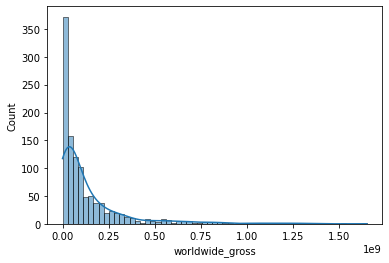

In [547]:
sns.histplot(df['worldwide_gross'], kde=True)
plt.show()